# Segmentation of Cell Cycles Images

SCC0251 - Image Processing

Name: Breno Lívio Silva de Almeida, NUSP: 10276675.

---

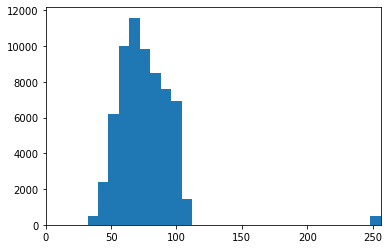

In [264]:
import numpy as np
from skimage import data
from skimage import filters
import matplotlib.pyplot as plt
from skimage import exposure
from skimage.morphology import disk
import matplotlib as mpl
from skimage import restoration
import imageio

cell = imageio.imread('Data/interphase/IMG_1667-2.jpg')

R, G, B = cell[:,:,0], cell[:,:,1], cell[:,:,2]
cellGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

fig, ax = plt.subplots(1, 1)
ax.hist(cellGray.ravel(), bins=32, range=[0, 256])
ax.set_xlim(0, 256);

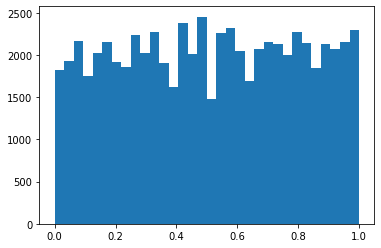

In [265]:
cellGray = exposure.equalize_hist(cellGray)

fig, ax = plt.subplots(1, 1)
ax.hist(cellGray.ravel(), bins=32);

## Region-based segmentation

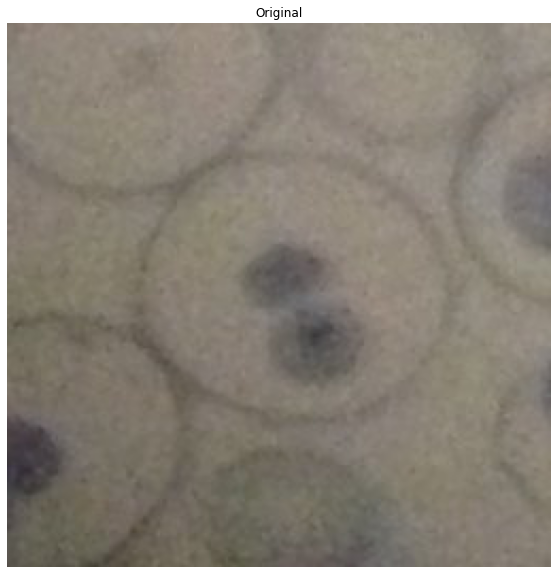

In [1]:
import skimage.morphology as morph
from skimage.measure import label
from skimage.filters import threshold_otsu
from skimage import io, color
import matplotlib.pyplot as plt
from skimage import exposure
from skimage import filters
import numpy as np

cellOriginal = io.imread('Data/mitosis/IMG_1681-1.jpg')

plt.figure(figsize = (10, 10))
plt.title("Original")
plt.axis("off")
plt.imshow(cellOriginal)
plt.show()

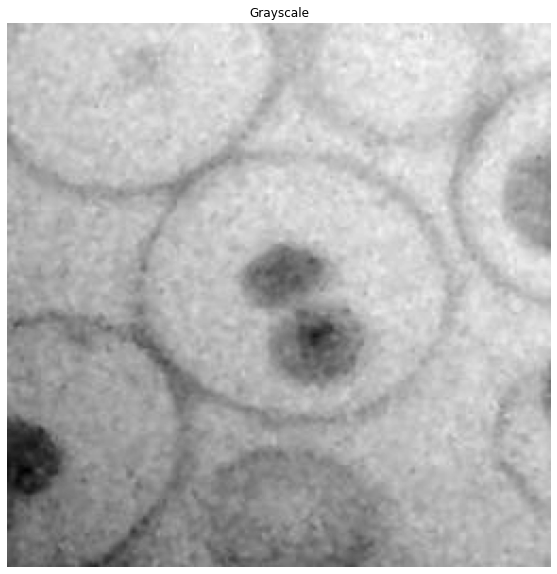

In [2]:
def convertGrayscale(img):
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    imgGray = 0.2989 * R + 0.5870 * G + 0.1140 * B

    return imgGray

cellGray = convertGrayscale(cellOriginal)

plt.figure(figsize = (10, 10))
plt.title("Grayscale")
plt.axis("off")
plt.imshow(cellGray, cmap = "gray")
plt.show()

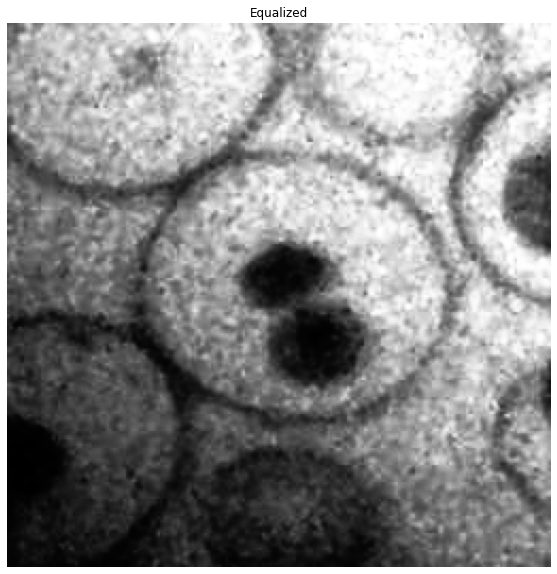

In [3]:
cellEq = exposure.equalize_hist(cellGray)

plt.figure(figsize = (10, 10))
plt.title("Equalized")
plt.axis("off")
plt.imshow(cellEq, cmap = "gray")
plt.show()

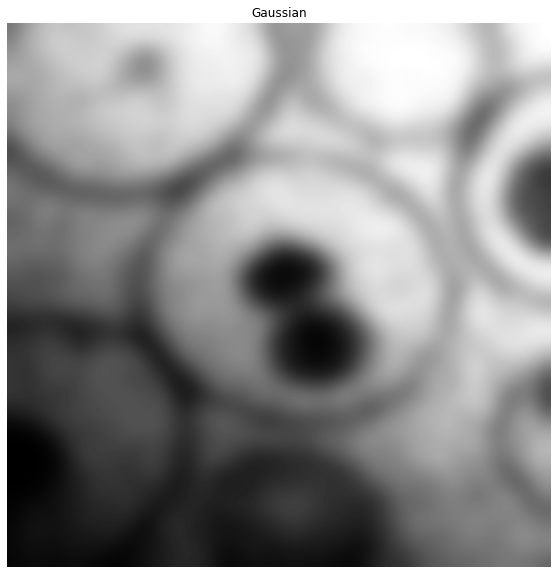

In [4]:
cellGaussian = filters.gaussian(cellEq, sigma = 5, mode = 'reflect')

plt.figure(figsize = (10, 10))
plt.title("Gaussian")
plt.axis("off")
plt.imshow(cellGaussian, cmap = "gray")
plt.show()

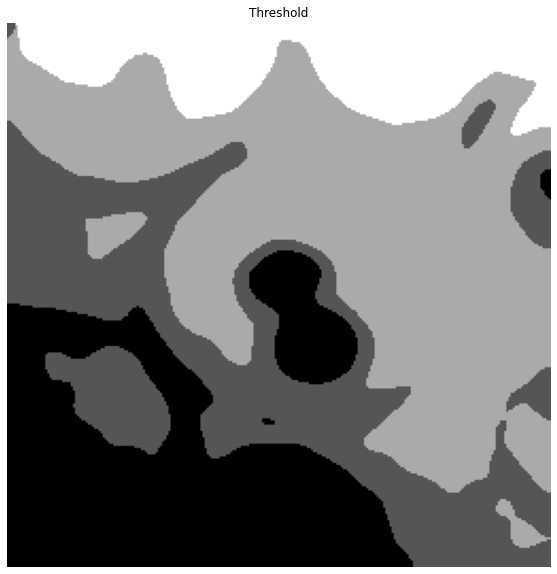

In [5]:
gray_r = cellGaussian.reshape(cellGaussian.shape[0] * cellGaussian.shape[1])

for i in range(gray_r.shape[0]):
    if gray_r[i] > gray_r.mean():
        gray_r[i] = 3
    elif gray_r[i] > 0.5:
        gray_r[i] = 2
    elif gray_r[i] > 0.25:
        gray_r[i] = 1
    else:
        gray_r[i] = 0

cellThresh = gray_r.reshape(cellGaussian.shape[0], cellGaussian.shape[1])

plt.figure(figsize = (10, 10))
plt.title("Threshold")
plt.axis("off")
plt.imshow(cellThresh, cmap = "gray")
plt.show()

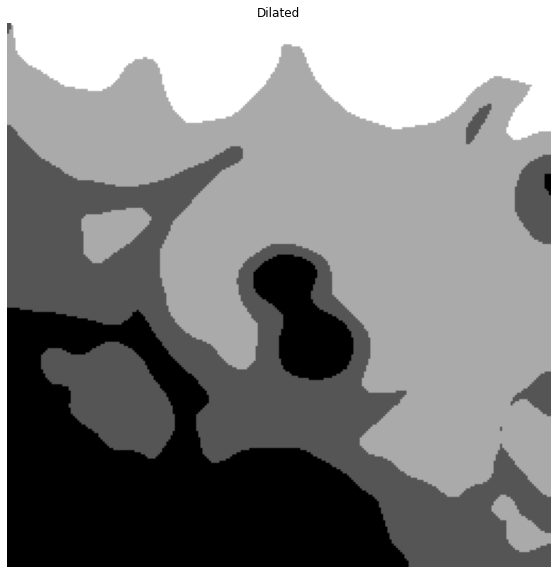

In [6]:
cellDilated = morph.dilation(cellThresh, morph.disk(2))

plt.figure(figsize = (10, 10))
plt.title("Dilated")
plt.axis("off")
plt.imshow(cellDilated, cmap = "gray")
plt.show()

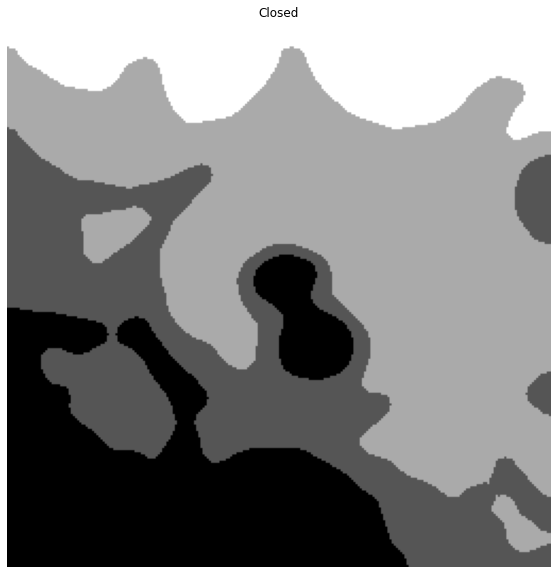

In [7]:
cellClosed = morph.closing(cellDilated, morph.disk(5))

plt.figure(figsize = (10, 10))
plt.title("Closed")
plt.axis("off")
plt.imshow(cellClosed, cmap = "gray")
plt.show()

<ipython-input-8-683bbd898082>:6: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  plt.imshow(color.label2rgb(L))


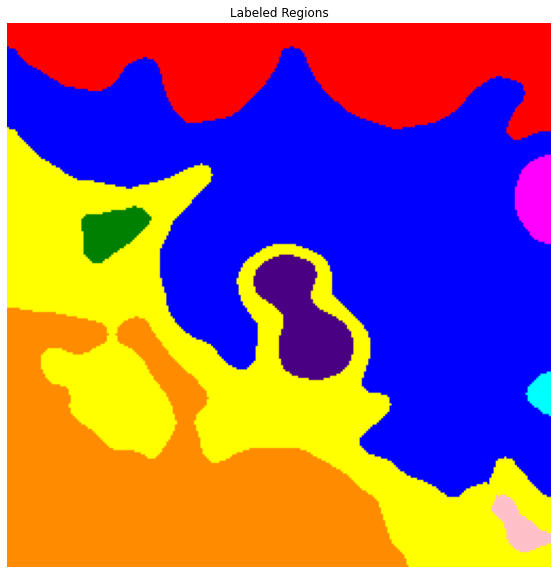

In [8]:
L = label(cellClosed + 1)

plt.figure(figsize = (10, 10))
plt.title("Labeled Regions")
plt.axis("off")
plt.imshow(color.label2rgb(L))
plt.show()

In [9]:
half_length = int(np.floor(np.size(L,1)/2))

L_blobs = L[half_length - 10: half_length + 11, half_length: half_length + 21]

counts = np.bincount(L_blobs.flatten())
L_cntr = np.argmax(counts)

print("Label of blob that contains the center pixel: {}".format(L_cntr))

Label of blob that contains the center pixel: 6


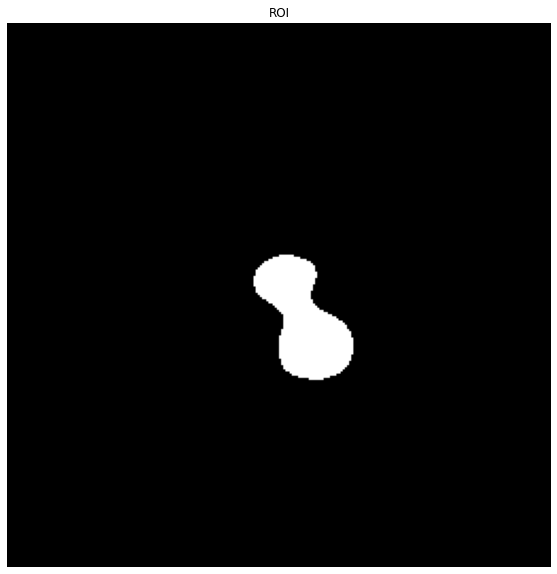

In [10]:
Seg = L
Seg[Seg != L_cntr] = 0
Seg[Seg == L_cntr] = 1

plt.figure(figsize = (10, 10))
plt.title("ROI")
plt.axis("off")
plt.imshow(Seg, cmap = "gray")
plt.show()

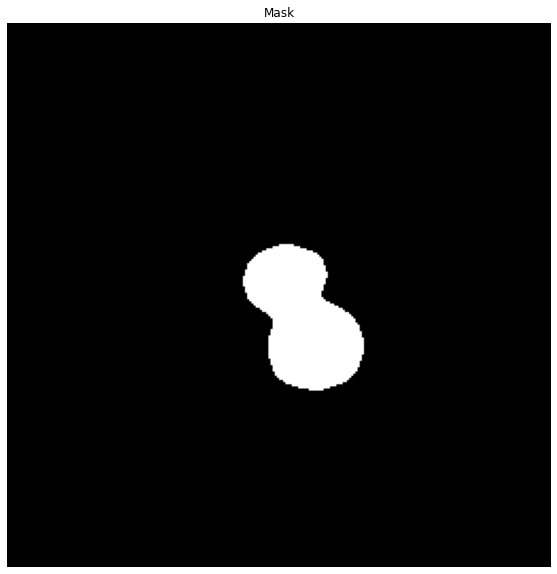

In [11]:
Mask = morph.dilation(Seg, morph.disk(5))

plt.figure(figsize = (10, 10))
plt.title("Mask")
plt.axis("off")
plt.imshow(Mask, cmap = "gray")
plt.show()

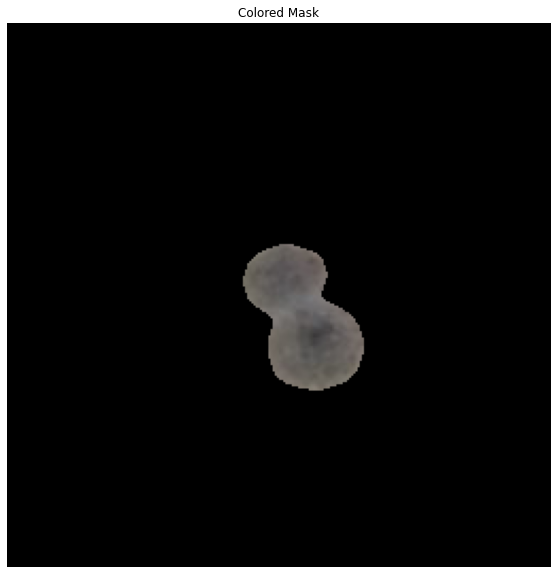

In [12]:
[indx, indy] = np.where(Mask == 0)
Color_Masked = cellOriginal.copy()
Color_Masked[indx,indy] = 0

plt.figure(figsize = (10, 10))
plt.title("Colored Mask")
plt.axis("off")
plt.imshow(Color_Masked)
plt.show()